# Exercise 5 - Variational Quantum Eigensolver

### VQE for Lithium Hydride (LiH) Molecule

#### -------------------------------------------------------------------------------------------------------------------

### Importing Necessary Libraries

In [17]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from qc_grader import grade_ex5

#### --------------------------------------------------------------------------------------------------------------------

### 1. Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers. There are multiple drivers available: `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver`.

We will be running `PySCFDriver`on the molecule to obtain a `QMolecule` data class which will contain the driver result.

In [18]:
# This representation is the interatomic distance in 3D space
molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.5474"

driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Results

In [19]:
print("No. of Electrons: {}".format(qmolecule.num_alpha + qmolecule.num_beta))
print("No. of Molecular Orbitals: {}".format(qmolecule.num_molecular_orbitals))
print("No. of Spin Orbitals: {}".format(2 * qmolecule.num_molecular_orbitals))
print("No. of Qubits Needed: {}".format(2 * qmolecule.num_molecular_orbitals))
print("Nuclear Repulsion Energy: {}".format(qmolecule.nuclear_repulsion_energy))

No. of Electrons: 4
No. of Molecular Orbitals: 6
No. of Spin Orbitals: 12
No. of Qubits Needed: 12
Nuclear Repulsion Energy: 1.0259348796432726


In [20]:
# To see all the available attributes of qmolecule
print(dir(qmolecule)) 

['BOHR', 'DEBYE', 'QMOLECULE_VERSION', 'Z', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_filename', 'atom_symbol', 'atom_xyz', 'core_orbitals', 'energy_shift', 'eri', 'filename', 'has_dipole_integrals', 'hcore', 'hcore_b', 'hf_energy', 'kinetic', 'load', 'log', 'mo_coeff', 'mo_coeff_b', 'mo_eri_ints', 'mo_eri_ints_ba', 'mo_eri_ints_bb', 'mo_occ', 'mo_occ_b', 'mo_onee_ints', 'mo_onee_ints_b', 'molecular_charge', 'multiplicity', 'nuclear_dipole_moment', 'nuclear_repulsion_energy', 'num_alpha', 'num_atoms', 'num_beta', 'num_molecular_orbitals', 'one_body_integrals', 'onee_to_spin', 'oneeints2mo', 'orbital_energies', 'orbital_energies_b', 'origin_driver_config', 'origin_driver_name', 'origin_dr

In [21]:
# To see the one body integrals
print(qmolecule.one_body_integrals) 

[[-4.73853724  0.10753914  0.1675853   0.          0.         -0.03026284
   0.          0.          0.          0.          0.          0.        ]
 [ 0.10753914 -1.51317577  0.03434669  0.          0.         -0.06802917
   0.          0.          0.          0.          0.          0.        ]
 [ 0.1675853   0.03434669 -1.12916229  0.          0.          0.03143223
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.14077094  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -1.14077094  0.
   0.          0.          0.          0.          0.          0.        ]
 [-0.03026284 -0.06802917  0.03143223  0.          0.         -0.9418187
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -4.73853724  0.10753914  0.1675853   0.          0.    

#### --------------------------------------------------------------------------------------------------------------------

### 2. Electronic structure problem
You can then create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).

We will reduces the `QMolecule` by removing some molecular orbitals which don't contribute much using `FreezeCoreTransformer`

In [22]:
# We will using one body integrals to determine which orbitals to remove.
fct = FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])

In [23]:
# ElectronicStructureProblem() will transform the qmolecule according to given transformers
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[fct])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

### 3. QubitConverter

Allows to define the mapping that you will use in the simulation. There are different mapping available but we will be using `ParityMapper` as we will be doing `two_qubit_reduction` and `z2symmetry` to reduce the no. of qubits as low as possible.

In [24]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[-1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

Results

In [25]:
print(qubit_op.z2_symmetries)

Z2 symmetries:
Symmetries:
IIIZII
ZIIIII
Single-Qubit Pauli X:
IIIXII
XIIIII
Cliffords:
0.7071067811865475 * IIIZII
+ 0.7071067811865475 * IIIXII
0.7071067811865475 * ZIIIII
+ 0.7071067811865475 * XIIIII
Qubit index:
[2, 5]
Tapering values:
[-1, 1]


#### --------------------------------------------------------------------------------------------------------------------

### 4. Initial state

By running a `HartreeFock` calculation for a given basis set and molecular geometry, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [26]:
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

Results

In [27]:
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


#### --------------------------------------------------------------------------------------------------------------------

### 5. Ansatz

One of the most important choices is the quantum circuit that you choose to approximate your ground state.

In [28]:
# Choose the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer,
                     skip_unentangled_qubits=False,insert_barriers=True)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state,reps=1)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

Results

In [29]:
print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐ ░                 ░  ┌──────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├─░───■─────────────░──┤ RY(θ[8]) ├»
        ├───┤    ├──────────┤├──────────┤ ░ ┌─┴─┐           ░  ├──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├─░─┤ X ├──■────────░──┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘ ░ └───┘┌─┴─┐      ░ ┌┴──────────┤»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────────────░──────┤ X ├──■───░─┤ RY(θ[10]) ├»
     ├──────────┤├──────────┤             ░      └───┘┌─┴─┐ ░ ├───────────┤»
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────░───────────┤ X ├─░─┤ RY(θ[11]) ├»
     └──────────┘└──────────┘             ░           └───┘ ░ └───────────┘»
«     ┌───────────┐
«q_0: ┤ RZ(θ[12]) ├
«     ├───────────┤
«q_1: ┤ RZ(θ[13]) ├
«     ├───────────┤
«q_2: ┤ RZ(θ[14]) ├
«     ├───────────┤
«q_3: ┤ RZ(θ[15]) ├
«     └───────────┘


#### --------------------------------------------------------------------------------------------------------------------

### 6. Backend

This is where you specify the simulator or device where you want to run your algorithm. We will focus on the `statevector_simulator` in this challenge.

In [30]:
backend = Aer.get_backend('statevector_simulator')

#### --------------------------------------------------------------------------------------------------------------------

### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU. A clever choice might reduce drastically the number of needed energy evaluations.  We will use the `COBYLA`

In [31]:
# Optimizers
optimizer_type = 'COBYLA'

if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=1000,rhobeg=5.0)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=1000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=1000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=1000)

#### --------------------------------------------------------------------------------------------------------------------

### 8. Exact eigensolver

For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a large molecule of your choice and see how slow this becomes. For very large systems you would run out of memory trying to store their wavefunctions.

In [32]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])

Results

In [33]:
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887060157347401


#### --------------------------------------------------------------------------------------------------------------------

### 9. VQE and initial parameters for the ansatz

Now we can import the VQE class and run the algorithm.

In [34]:
# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 1000, Energy: -1.0862248602929456, Std: 0.0'

Results

In [35]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1000,
    'eigenstate': array([ 9.41944182e-05+1.29249641e-03j,  2.94065280e-03-1.47125885e-03j,
        8.49857538e-03+7.70674750e-03j,  2.29462982e-01-9.65029328e-01j,
        7.94503590e-03-5.27258176e-02j,  5.82094492e-04-9.61448625e-05j,
        2.19798827e-04+3.13762016e-04j,  9.43306506e-03-1.52777092e-02j,
       -2.25007914e-04-2.12337512e-03j,  1.72257905e-05-1.02032669e-05j,
        8.12705460e-06-4.93582908e-06j, -7.66639783e-04+2.02048146e-04j,
       -2.72056965e-02+1.09563340e-01j, -1.11391902e-03+8.44198615e-05j,
       -2.25661368e-04-2.80270849e-04j,  1.93476311e-03-6.47113926e-04j]),
    'eigenvalue': -1.0862249029486517,
    'optimal_parameters': {   ParameterVectorElement(θ[9]): 6.2765303705816455,
                              ParameterVectorElement(θ[3]): 0.4417126004049145,
                              ParameterVectorElement(θ[4]): 0.24368759508277743,
                              ParameterVector

#### --------------------------------------------------------------------------------------------------------------------

### 10. Scoring function

We need to judge how good are your VQE simulations, your choice of ansatz/optimizer. For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs. 
But you have to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa, which may be hard to reach depending on the problem. 
You have to reach the accuracy we set in a minimal number of CNOTs to win the challenge. 
The lower the score the better!

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,-6537.273430,True,198
1,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,518.060068,False,198
2,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,503.313980,False,198
3,COBYLA,TwoLocal,12,72,"['ry', 'rz']",cx,full,3.0,503.313980,False,198
4,COBYLA,TwoLocal,10,60,"['ry', 'rz']",cx,full,3.0,348.702061,False,135
...,...,...,...,...,...,...,...,...,...,...,...
185,COBYLA,TwoLocal,4,16,"['ry', 'rz']",cx,linear,1.0,18.347551,False,3
186,COBYLA,TwoLocal,4,16,"['ry', 'rz']",cx,linear,1.0,18.347551,False,3
187,COBYLA,TwoLocal,6,24,"['ry', 'rz']",cx,linear,1.0,12.112448,False,5
188,COBYLA,TwoLocal,4,16,"['ry', 'rz']",cx,linear,1.0,2.480476,True,3


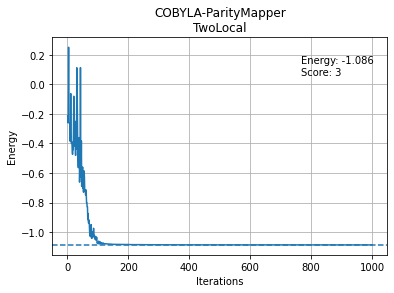

In [36]:
# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

#### --------------------------------------------------------------------------------------------------------------------

### 11. Grading

In [37]:
freeze_core = True
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.



#### --------------------------------------------------------------------------------------------------------------------